In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time, VolumeGrouper
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate, calibrate_multiple, get_data
from datastore import Store

In [197]:
sym = 'NQ'
volume = 10000
start_date = '20180601'
end_date = '20181231'

In [200]:
#data = VolumeGrouper(get_data(sym, start_date, end_date), volume).df
data = get_data(sym, start_date, end_date)

In [6]:
def ema(data, fast, slow):
    data = data.copy()
    data['ema_slow'] = data.close.ewm(span=slow).mean()
    data['ema_fast'] = data.close.ewm(span=fast).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    return data['ema_diff']

In [7]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [8]:
def carver(data, periods):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    return np.sign(data['breakout'])

In [ ]:
day = 1365

In [214]:
periods = int(day/16)
data['max'] = data.close.rolling(periods).max()
data['min'] = data.close.rolling(periods).min()
data['mid'] = data[['min', 'max']].mean(axis=1)
data['breakout'] = (data['close'] - data['mid']).ewm(span=20).mean()
data['spread'] = data['max'] - data['min']
data['filter'] = (data['spread'] > 80)
data['forecast'] = np.sign(data['breakout']) * data['filter']

In [215]:
data.spread.mean(), data.spread.std()

(27.057356907548545, 24.290407774688912)

In [216]:
#data['forecast'] = carver(data, int(day/16))
data.tail()

,open,high,low,close,volume,average,barCount,max,min,mid,breakout,spread,filter,forecast
date,,,,,,,,,,,,,,
2018-12-31 22:55:00,6350.75,6352.50,6350.75,6352.50,19,6351.500,16,6354.75,6299.25,6327.0,22.956303,55.5,False,0.0
2018-12-31 22:56:00,6352.50,6353.25,6352.00,6352.50,61,6352.725,36,6354.75,6299.25,6327.0,23.198559,55.5,False,0.0
2018-12-31 22:57:00,6352.50,6353.25,6351.75,6351.75,17,6352.350,13,6354.75,6299.25,6327.0,23.346316,55.5,False,0.0
2018-12-31 22:58:00,6352.00,6352.50,6352.00,6352.25,29,6352.200,22,6354.75,6299.25,6327.0,23.527619,55.5,False,0.0
2018-12-31 22:59:00,6352.00,6353.50,6351.75,6352.25,50,6352.675,37,6354.75,6299.25,6327.0,23.691655,55.5,False,0.0


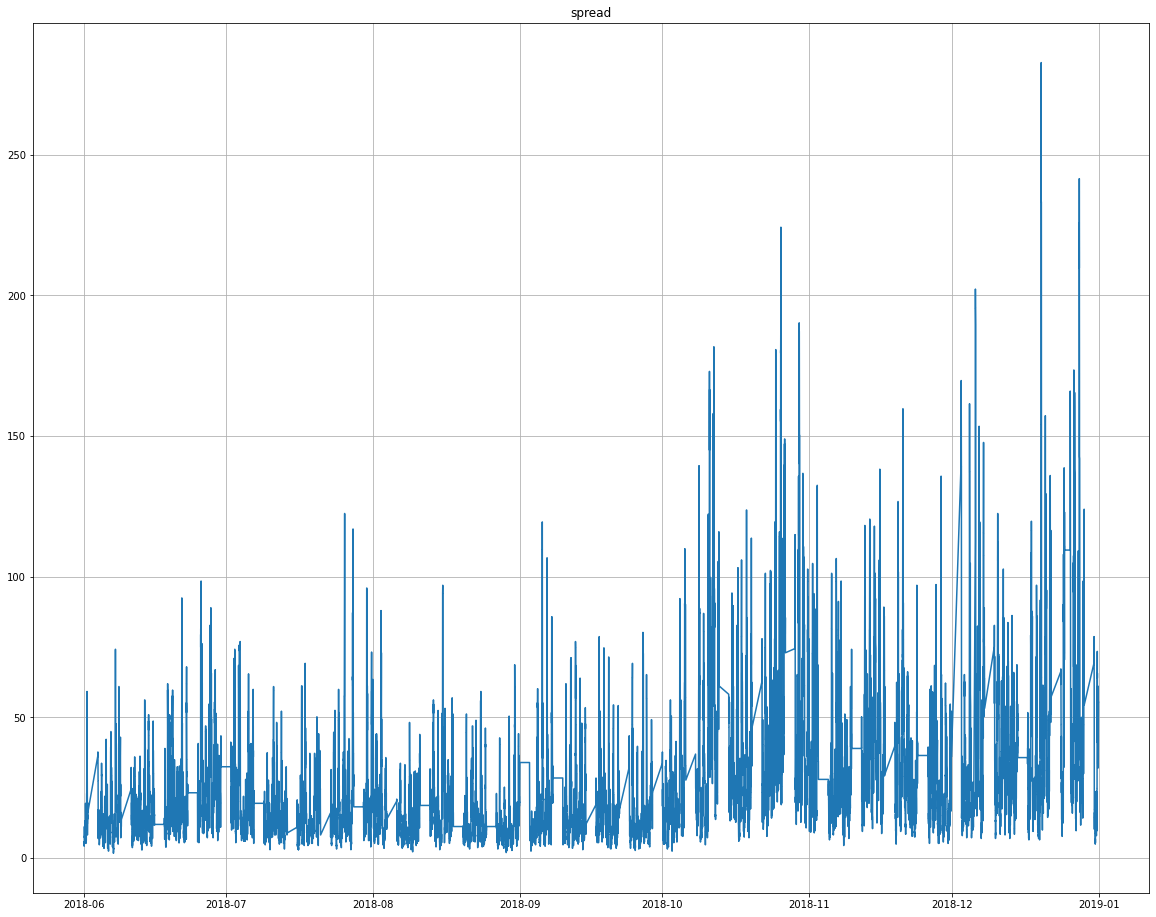

In [217]:
plot(data['spread'])

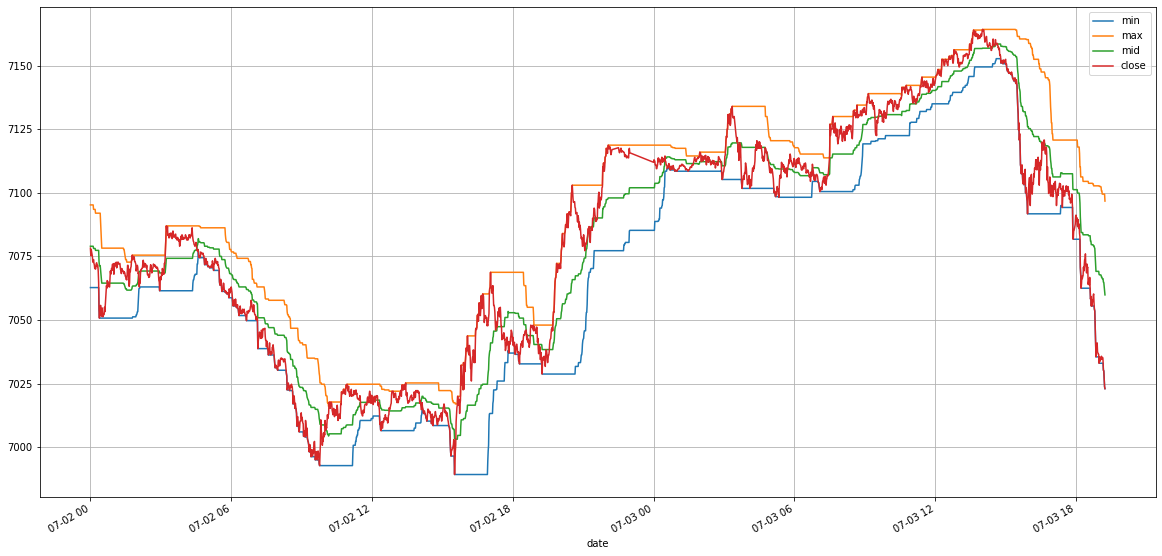

In [218]:
c = data.loc['20180701':'20180703']
c[['min', 'max', 'mid', 'close']].plot(figsize=(20,10), grid=True);

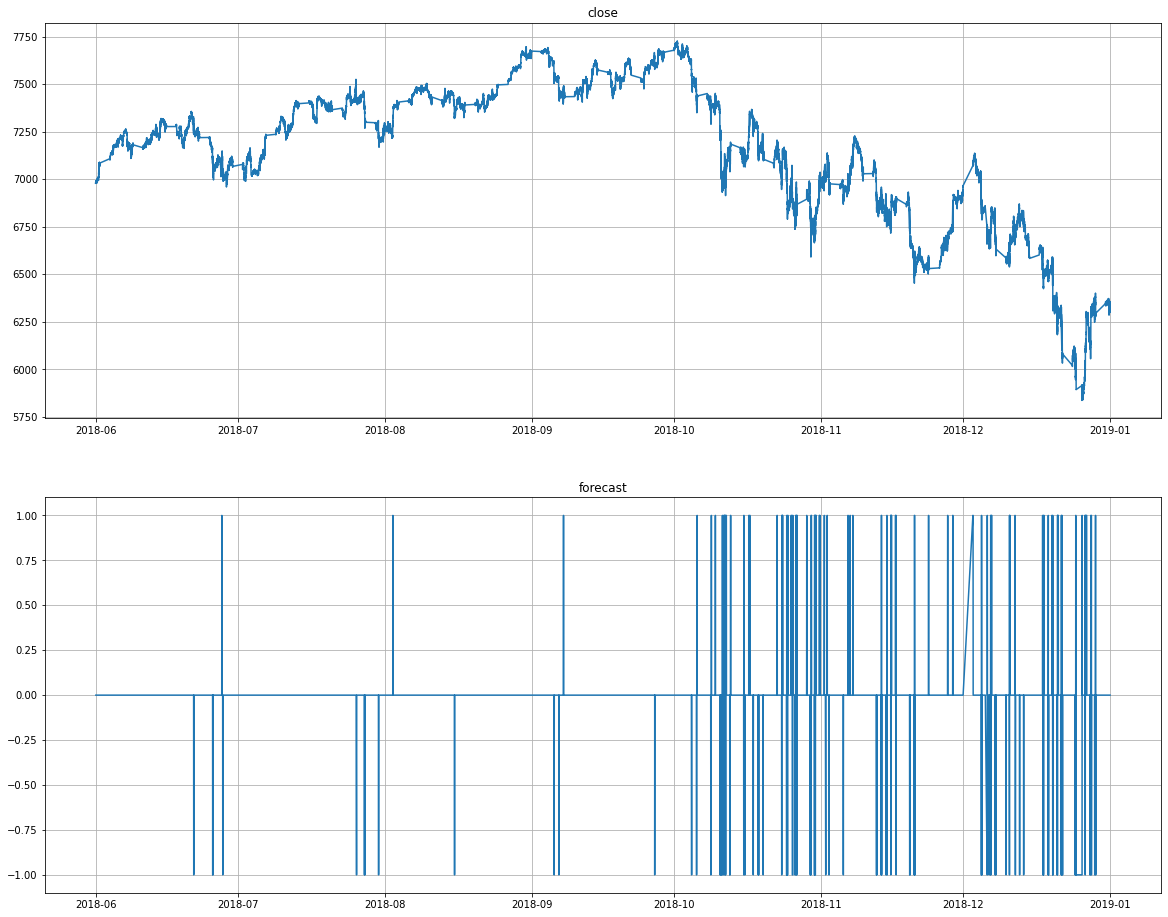

In [219]:
plot(data[['close', 'forecast']])

In [220]:
out = summary(data, slip=1.5)
out.stats

,0
Annual return,-0.108989
Cumulative returns,-0.0668109
Annual volatility,0.0914075
Sharpe ratio,-1.21654
Calmar ratio,-1.04786
Stability,0.752587
Max drawdown,-0.104011
Omega ratio,0.699939
Sortino ratio,-1.55375
Skew,-1.13989


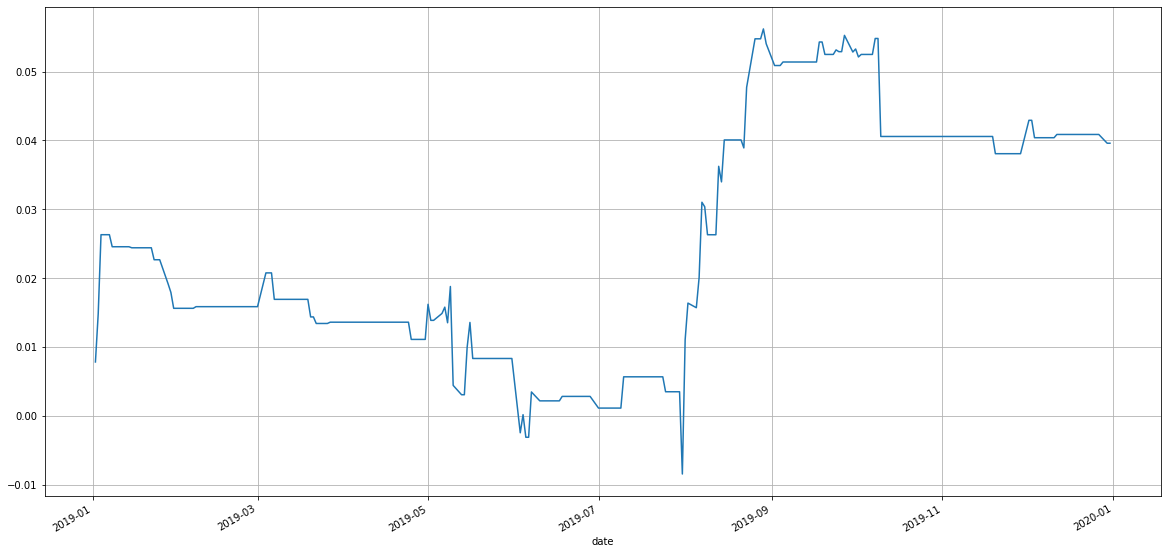

In [196]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [17]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

KeyError: 5

In [ ]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [ ]:
out.dfs[0].loc['20190719 2:40':'20190720'].head(30)

In [ ]:
out.positions[0].head(30)

In [ ]:
out.positions[0].sort_values('pnl')

In [ ]:
d = data.copy()
d['max'] = data.close.rolling(day*2).max()
d['min'] = data.close.rolling(day*2).min()
d['mid'] = d[['min', 'max']].mean(axis=1)
d['breakout'] = d['close'] - d['mid']
d['breakout_norm'] = d['breakout'] / (d['max'] - d['min'])
d['breakout_mean'] = d['breakout_norm'].ewm(span=day*2/3).mean()
d=d.loc['20190719':'20190720']
d[['max', 'min', 'mid', 'close',]].plot(figsize=(20,10), grid=True);

In [ ]:
data.loc['20190719 2:40':'20190720'].head(30)

In [ ]:
def test_carver(data, periods):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['span'] = (data['max'] - data['min'])
    data['breakout_norm'] = data['breakout'] / data['span']
    data[f'carver_{periods}'] = data['breakout_norm'].ewm(span=periods/3).mean()
    return data

In [ ]:
t=test_carver(data, day*2).loc['20190719 2:40':'20190720'].head(30)
t

In [ ]:
t[['breakout_norm','carver_2730']].loc['20190719 2:40':'20190720'].plot(figsize=(20,10), grid=True)